## **Building a Fast, Faithful F1 Lap-Time Simulator with FastF1 and a Tiny Physics Engine**  

*(an improved fork of my friend [Raul Garcia](https://github.com/pmraulgarcia)’s great project. Please read his repo first!)*

Start here: If you’re new to this topic, I highly recommend reading [Raul Garcia](https://github.com/pmraulgarcia/Formula1_Race_Simulator)’s original repo first. It lays out the core pipeline clearly and is the foundation of this work.  
👉 [The original repo](https://github.com/pmraulgarcia/Formula1_Race_Simulator)

If you’ve ever watched a fastest lap and wondered “how much of this is driver, how much is car?”, this walkthrough is for you. We’ll turn raw FastF1 telemetry into a working lap-time simulator that feels credible. One that respects aero drag and downforce, tyre-grip trade-offs, DRS, and even a rev-limit! Then validate it by laying the simulated speed trace on top of the real one.

The goal isn’t to recreate a full vehicle-dynamics package; it’s to build a small, transparent engine that you can read in one sitting, calibrate in minutes, and trust enough to ask “what if?”. On a typical session, this fork lands in the ~97–99% lap-time accuracy range after a quick top-speed calibration.


### **What’s new vs the original (why accuracy improved)**  

- **Cleaner telemetry base**: nearest-time merge of car + position with gap filling; smoother, robust curvature and derived lateral-g.  
- **More explicit physics**: separate CdA/ClA (*drag area / downforce area; i.e., $F_{\text{drag}} = \frac{1}{2} \rho v^2 C_d A$ and $F_{\text{down}} = \frac{1}{2} \rho v^2 C_l A,$*) with DRS multipliers; power-balanced terminal speed + optional rev-limit; friction ellipse (shares grip between braking/accel and cornering).  
- **Sharper segmentation**: short bins (6–10 m) and a score-based corner/straight label with rolling-median smoothing.  
- **Converged speed profile**: forward/backward sweeps with lateral-g reservation (DRS closed while braking).  
- **Trustworthy timing**: integrate on the real telemetry distance grid (∫ ds/v), optional upshift penalty, and clear MAE/RMSE overlays.



### **Roadmap**  

1. Load & prepare telemetry (merge, XY fill, curvature κ(s), lateral-g)  
2. Vehicle model (CdA/ClA, DRS, terminal speed, friction ellipse, rev-cap, quick CdA retarget)  
3. Track discretization (6–10 m bins, score → corner/straight, radius, DRS)  
4. Physics speed limits (corners: steady corner limit; straights: terminal speed)  
5. Optimize (forward/backward sweeps; reserve lateral-g)  
6. Visualize (real vs sim overlay on the same distance grid, cumulative time, acceleration)  
7. Animate (time-based motion with live telemetry pointers)  
8. Summary: Real vs simulated lap time, delta & accuracy  

We’ll demonstrate on [e.g., 2025 Spanish Grand Prix — Race session], but you can point the script at any session by changing `year`, `gp_name`, and `session_type`.


In [103]:
# ============================================================================
# STEP 1 — Imports & global setup
# ============================================================================

# Stdlib
from pathlib import Path
import warnings
import logging

# Core numerics & data
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib import animation           # for GIF/MP4 lap animations
from matplotlib.gridspec import GridSpec   # flexible subplot layout

# SciPy utilities
from scipy import interpolate, optimize
from scipy.signal import savgol_filter

# FastF1 (timing, telemetry, weather, etc.)
import fastf1

# --- Tidy the console output ---
# Hide noisy warnings (comment out while debugging if you want to see them)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Quiet FastF1 logs (keep only errors)
fastf1.set_log_level(logging.ERROR)

# --- FastF1 on-disk cache (highly recommended) ---
# Why a cache?
#   - Speeds up reruns dramatically: session data is downloaded once, then reused.
#   - Reduces network dependency and rate-limit hits; we can work offline once cached.
#   - Improves reproducibility: we use the same raw timing/telemetry snapshot across runs.
# What it stores: timing, telemetry, weather, track status per session.
cache_dir = "f1_cache"
Path(cache_dir).mkdir(parents=True, exist_ok=True)

# API name differs across FastF1 versions — try both for compatibility
try:
    fastf1.Cache.enable_cache(cache_dir)   # newer API
except AttributeError:
    try:
        fastf1.Cache.enable(cache_dir)     # older API
    except Exception as e:
        print(f"⚠️ Could not enable FastF1 cache at '{cache_dir}': {e}")
            

In [104]:
# ============================================================================
# Utility — integrate simulated time on the real telemetry distance grid
# ============================================================================

def sim_time_from_real_grid(segments_df: pd.DataFrame, telemetry: pd.DataFrame):
    """
    Interpolate the simulated segment speeds onto the real telemetry distance
    samples and integrate dt = ds / v to obtain cumulative time.

    Args:
        segments_df: DataFrame with columns ['start','end','optimized_speed'].
        telemetry:   DataFrame with columns ['Distance','Speed', ...].

    Returns:
        dist (np.ndarray): telemetry distance samples used (m)
        sim_speed_on_real (np.ndarray): simulated speed at those samples (km/h)
        cum_time (np.ndarray): cumulative simulated time (s)
    """
    # Real distance samples (sorted, de-duplicated)
    tel = telemetry.sort_values('Distance').reset_index(drop=True)
    dist = tel['Distance'].to_numpy(float)

    # Restrict to overlap with segment coverage to avoid extrapolation
    s_max = float(min(dist[-1], segments_df['end'].max()))
    dist = dist[dist <= s_max]

    # Enforce non-decreasing distances and drop zero-steps (GPS jitter guard)
    dist = np.maximum.accumulate(dist)
    step_mask = np.r_[True, np.diff(dist) > 1e-9]
    dist = dist[step_mask]

    # Simulated speeds at segment midpoints
    seg_mid = 0.5 * (segments_df['start'].to_numpy(float) + segments_df['end'].to_numpy(float))
    sim_speed = segments_df['optimized_speed'].to_numpy(float)

    # Guard: make x monotonic & unique for interpolation
    order = np.argsort(seg_mid)
    seg_mid = seg_mid[order]
    sim_speed = sim_speed[order]
    seg_mid, uniq_idx = np.unique(seg_mid, return_index=True)
    sim_speed = sim_speed[uniq_idx]

    # Interpolate sim speeds to the real distance grid and integrate time
    sim_speed_on_real = np.interp(dist, seg_mid, sim_speed)
    v_mps = np.clip(sim_speed_on_real / 3.6, 1e-3, None)

    ds = np.diff(dist, prepend=dist[0])   # first step = 0
    dt = ds / v_mps
    cum_time = np.cumsum(dt)

    return dist, sim_speed_on_real, cum_time



----------------------------------------
STEP 1–2: Loading Circuit Data
----------------------------------------
Loading 2025 British Grand Prix FP2 session...

✅ Session loaded successfully!
Curvature check — radius percentiles (m): p10=63, p50=297, p90=8034, p99=52268

📊 Circuit Statistics:
 Track Length: 5816 meters
 Fastest Lap: 85.816 seconds
 Driver: NOR
 Max Speed: 320.0 km/h
 Corners identified (quick heuristic): 5

----------------------------------------
STEP 3: Vehicle Model
----------------------------------------
CdA scaled ×1.675 → 1.842  (v_power 380.0 → 320.0 km/h)
🏎️ Vehicle Performance Characteristics:
 Max corner speed (R=50 m):  136.8 km/h
 Max corner speed (R=100 m): 302.7 km/h

----------------------------------------
STEP 4: Track Discretization
----------------------------------------
📍 Track Discretization Complete:
 Total segments:  321
 Corner segments: 179

----------------------------------------
STEP 5: Physics-Only Performance Limits
--------------------

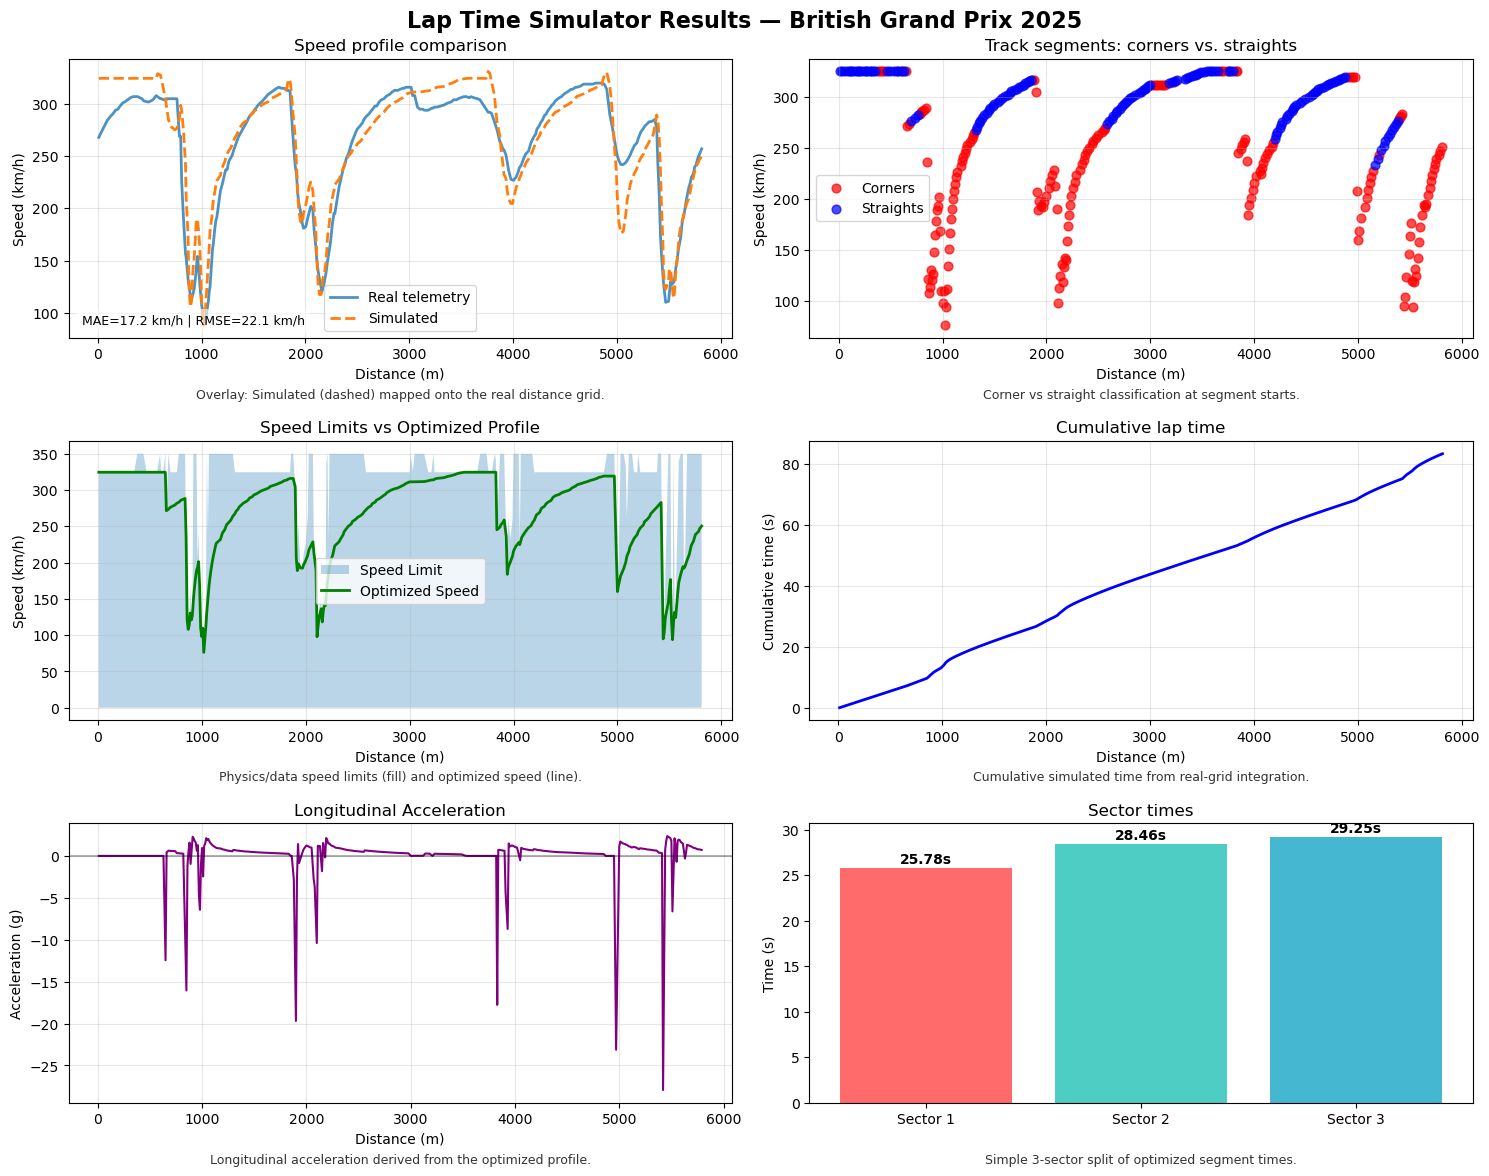


----------------------------------------
STEP 8: Track Animation & Advanced Visualization
----------------------------------------


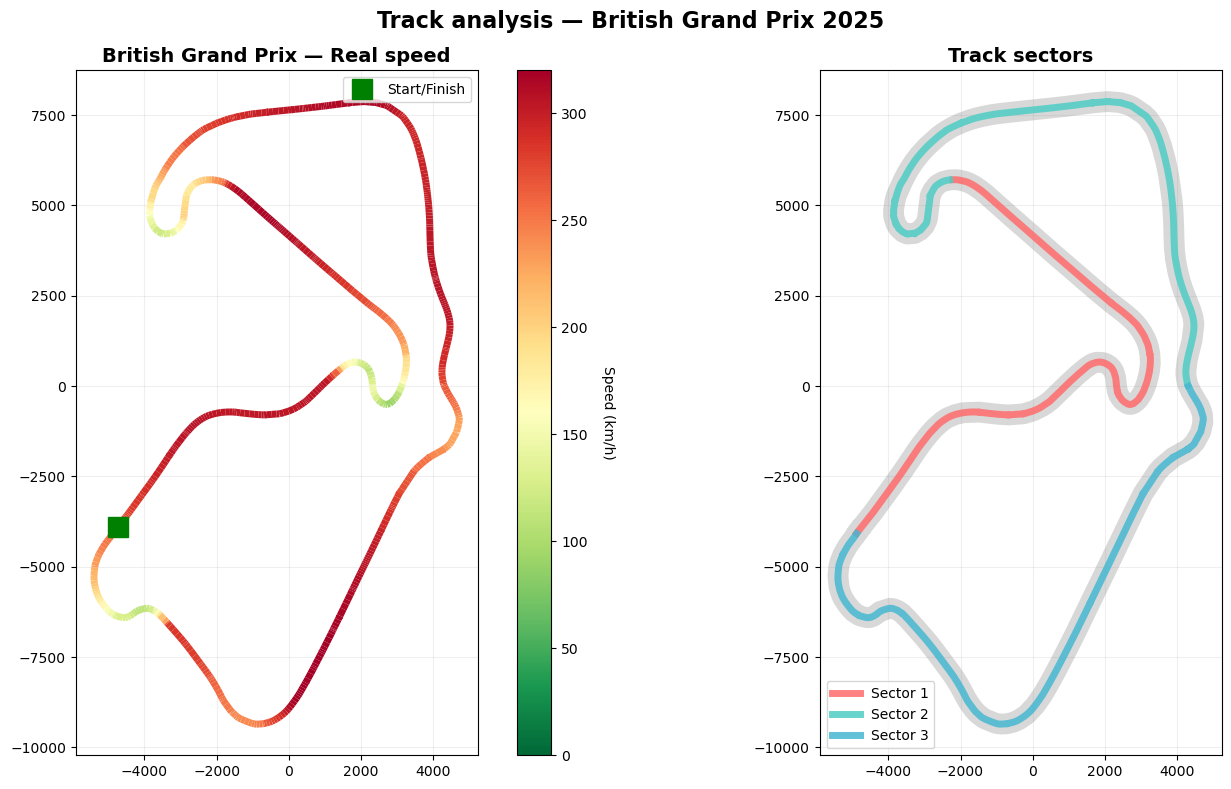

🎬 Creating animated visualization…
Saving animation to 2025_7_BritishGrandPrix_FP2_lap_animation.gif…
✅ Animation saved!


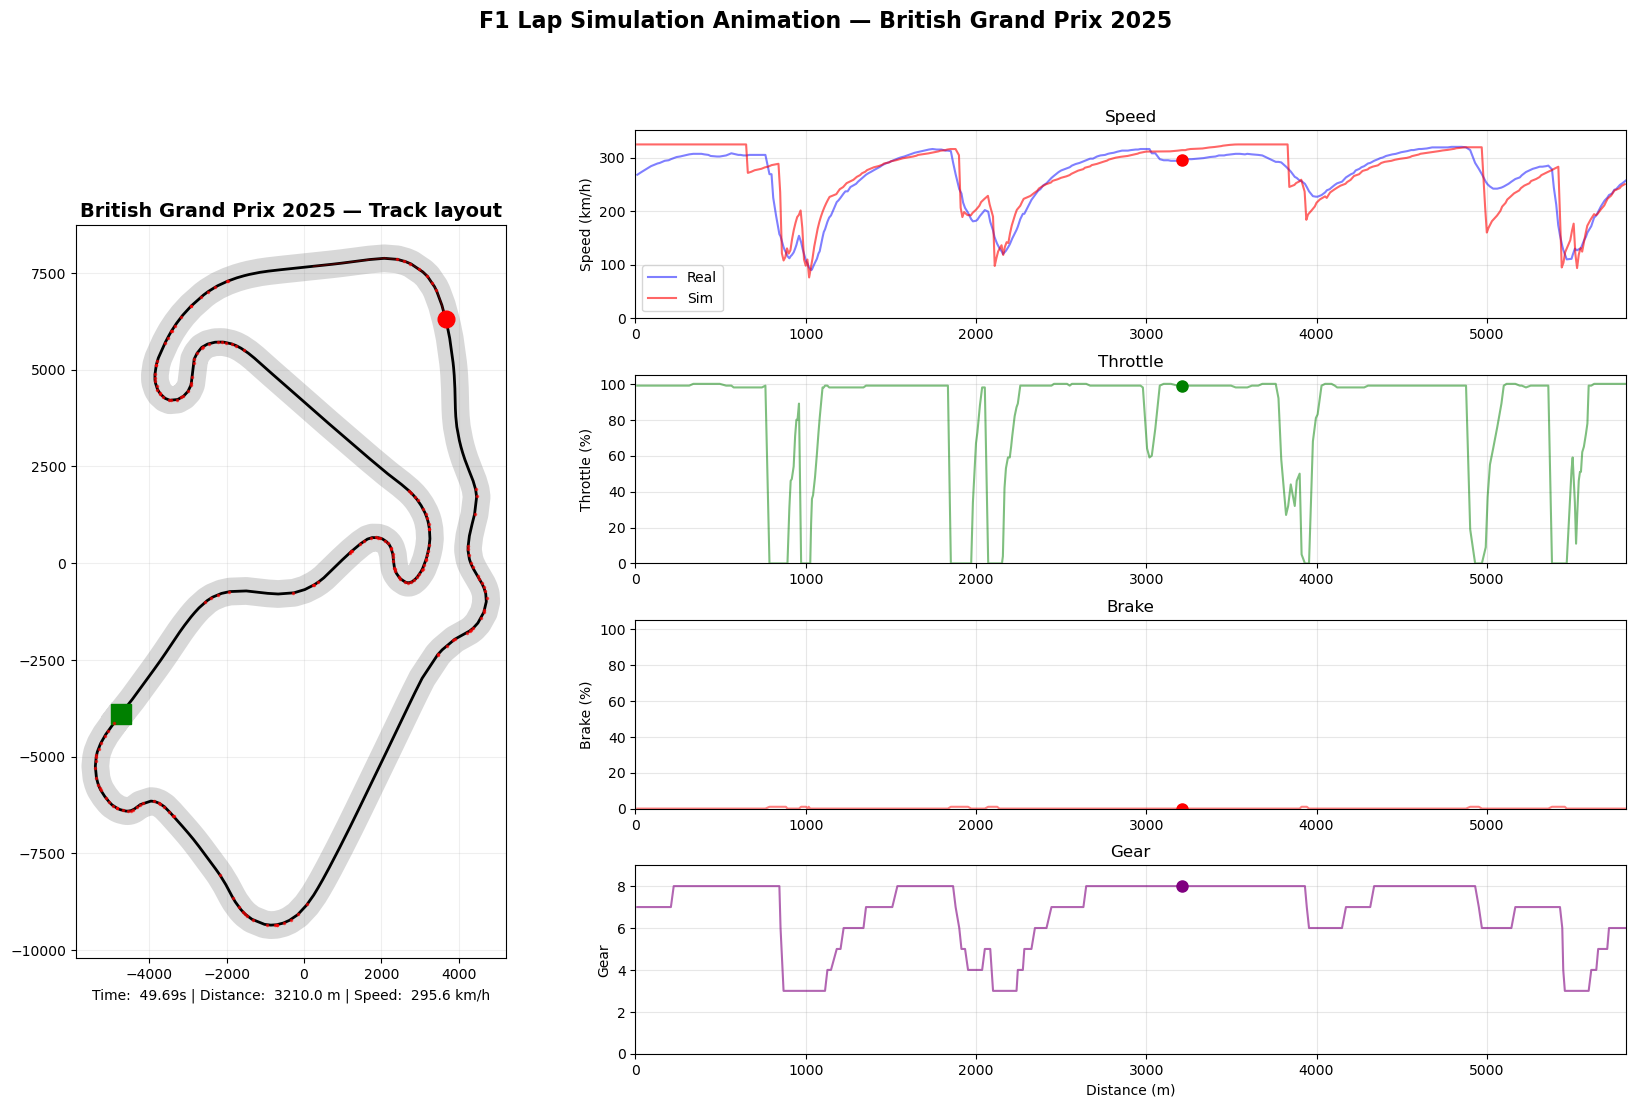

✅ Animation created!

📊 SIMULATION SUMMARY
Circuit: British Grand Prix 2025
Track Length: 5816 m
Number of Segments: 321
Number of Corners: 179

LAP TIMES:
 Real: 85.816 s
 Simulated: 84.846 s
 Difference: -0.970 s
 Accuracy: 98.9%

SPEED STATISTICS (optimized):
 Average: 255.1 km/h
 Maximum: 324.5 km/h
 Minimum: 76.3 km/h


In [105]:
# ============================================================================
# STEP 2 — Circuit data (session load, telemetry merge, curvature)
# ============================================================================

class CircuitData:
    """
    Load a FastF1 session and prepare a clean telemetry table for the fastest lap:
      • car channels aligned to distance
      • XY position merged (with interpolation/ffill/bfill)
      • air density from weather
      • curvature κ from heading change (stable vs. raw second derivatives)
      • derived lateral g

    Attributes set after `get_fastest_lap_telemetry()`:
      self.telemetry     : DataFrame with Distance, Speed, Throttle/Brake/… + X,Y,(Z), curvature, lat_g
      self.position_data : X,Y,(Z) columns if available
      self.circuit_info  : dict(track_length, lap_time, driver, max_speed, air_density)
      self.fastest_lap   : the FastF1 Lap object for the fastest lap
    """

    def __init__(self, year, gp_name=None, session_type='R', round_no=None, cache_dir='f1_cache'):
        self.year = year
        self.gp_name = gp_name
        self.round_no = round_no
        self.session_type = session_type
        self.cache_dir = cache_dir
        self.session = None
        self.fastest_lap = None
        self.telemetry = None
        self.circuit_info = {}
        self.position_data = None

    def load_session(self):
        print(f"Loading {self.year} {self.gp_name} {self.session_type} session...")
        self.session = fastf1.get_session(self.year, self.gp_name, self.session_type)
        # Be explicit about what to load
        self.session.load(laps=True, telemetry=True, weather=False, messages=False)
        # Sanity check: do we actually have laps?
        if not hasattr(self.session, '_laps') or self.session.laps.empty:
            raise RuntimeError(
                "Lap data was not loaded. Check network access to F1 Live Timing "
                "(e.g., livetiming.formula1.com) or try a different session."
            )
        print("\n✅ Session loaded successfully!")

    def get_fastest_lap_telemetry(self):
        """
        Build a distance‑sorted telemetry table for the fastest lap:
          1) merge car data and position via nearest‑time asof with a safe tolerance,
          2) interpolate/ffill/bfill XY to avoid curvature gaps,
          3) compute air density (ρ) from session weather (fallback to ISA),
          4) compute curvature κ = |dθ/ds| with light Savitzky–Golay smoothing,
          5) compute lateral g from v² κ / g.
        """
        if self.session is None:
            raise RuntimeError("Session is not loaded. Call load_session() first.")

        # Fastest lap selection
        self.fastest_lap = self.session.laps.pick_fastest()

        # Car channels with Distance; Position channels
        car = self.fastest_lap.get_car_data().add_distance().reset_index()
        pos = self.fastest_lap.get_pos_data().reset_index()

        # Common time column differs across FastF1 versions
        time_col = "SessionTime" if ("SessionTime" in car.columns and "SessionTime" in pos.columns) else "Time"

        # Keep only time + XY(Z) from position and merge with a slightly loose tolerance
        keep_cols = [time_col, "X", "Y"] + (["Z"] if "Z" in pos.columns else [])
        pos = pos[keep_cols]

        tel = pd.merge_asof(
            car.sort_values(time_col),
            pos.sort_values(time_col),
            on=time_col,
            direction="nearest",
            tolerance=pd.Timedelta("300ms")  # tolerant to occasional GPS sparsity
        ).sort_values("Distance").reset_index(drop=True)

        # Interpolate/ffill/bfill XY so curvature is not lost to NaNs
        for col in ("X", "Y", "Z"):
            if col in tel.columns:
                tel[col] = tel[col].interpolate("linear", limit_direction="both").ffill().bfill()

        # Air density from weather (fallback to ISA 1.225 kg/m³)
        rho = 1.225
        try:
            wd = self.session.weather_data.iloc[0]
            T = float(wd["AirTemp"]) + 273.15  # °C → K
            p = float(wd["Pressure"]) * 100.0  # hPa → Pa
            rho = p / (287.05 * T)
        except Exception:
            pass

        # Save basics
        self.telemetry = tel
        pos_cols = [c for c in ("X", "Y", "Z") if c in tel.columns]
        self.position_data = tel[pos_cols].copy()
        self.circuit_info = {
            "track_length": float(tel["Distance"].max()),
            "lap_time": float(self.fastest_lap["LapTime"].total_seconds()),
            "driver": str(self.fastest_lap["Driver"]),
            "max_speed": float(tel["Speed"].max()),
            "air_density": float(rho),
        }

        # --- Curvature via heading derivative (robust against GPS jitter) ---
        if {"X", "Y"}.issubset(tel.columns) and tel[["X", "Y"]].notna().any().all():
            s = tel["Distance"].to_numpy(float)
            x = tel["X"].to_numpy(float)
            y = tel["Y"].to_numpy(float)

            # Smooth XY lightly (~1% window, must be odd)
            n = len(s)
            w = max(7, (n // 100) * 2 + 1)
            w = min(w, n - (1 - n % 2))  # keep odd and ≤ n
            xs = savgol_filter(x, w, 2, mode="interp")
            ys = savgol_filter(y, w, 2, mode="interp")

            dx = np.gradient(xs, s)
            dy = np.gradient(ys, s)

            # heading and curvature κ = |dθ/ds|
            theta = np.unwrap(np.arctan2(dy, dx))
            kappa = np.abs(np.gradient(theta, s))
            kappa = np.clip(kappa, 0.0, 0.3)  # clip extreme spikes (1/m)

            self.telemetry["curvature"] = kappa
            v_mps = tel["Speed"].to_numpy(float) / 3.6
            self.telemetry["lat_g"] = (v_mps * v_mps * kappa) / 9.81
        else:
            self.telemetry["curvature"] = 0.0
            self.telemetry["lat_g"] = 0.0

        # Quick curvature sanity print (radius percentiles)
        kappa = self.telemetry["curvature"].to_numpy(float)
        with np.errstate(divide="ignore"):
            radius = np.where(kappa > 1e-6, 1.0 / kappa, np.inf)
        p10, p50, p90, p99 = np.nanpercentile(radius, [10, 50, 90, 99])
        print(f"Curvature check — radius percentiles (m): p10={p10:.0f}, p50={p50:.0f}, p90={p90:.0f}, p99={p99:.0f}")

        return self.telemetry

    def get_track_coordinates(self):
        """
        Return (X, Y) arrays for plotting the track layout.
        Falls back to a simple circle if XY is unavailable.
        """
        if {"X", "Y"}.issubset(self.telemetry.columns):
            return self.telemetry["X"].to_numpy(), self.telemetry["Y"].to_numpy()
        print("⚠️ Position data not available, using simplified circular track layout")
        distances = self.telemetry["Distance"].to_numpy()
        angles = 2 * np.pi * distances / distances[-1]
        return np.cos(angles) * 1000.0, np.sin(angles) * 1000.0

    def identify_corners(self, speed_threshold_pct: float = 0.85):
        """
        Very simple corner finder for quick stats:
        labels a corner whenever Speed < (threshold_pct × max_speed), contiguous in distance.
        Returns a list of dicts with start, end, min_speed.
        """
        max_speed = float(self.telemetry["Speed"].max())
        threshold = max_speed * float(speed_threshold_pct)

        corners = []
        in_corner = False
        corner_start = 0.0

        for dist, speed in zip(self.telemetry["Distance"], self.telemetry["Speed"]):
            if (speed < threshold) and not in_corner:
                in_corner = True
                corner_start = float(dist)
            elif (speed >= threshold) and in_corner:
                in_corner = False
                segment = self.telemetry[(self.telemetry["Distance"] >= corner_start) &
                                         (self.telemetry["Distance"] <= float(dist))]
                corners.append({
                    "start": corner_start,
                    "end": float(dist),
                    "min_speed": float(segment["Speed"].min()) if not segment.empty else float("nan"),
                })
        return corners

# ============================================================================
# STEP 3 — Vehicle model (aero + tyres + friction circle + DRS)
# ============================================================================

class VehicleModel:
    """
    Simplified F1-ish physics model used to bound speed by:
      • Straights: terminal speed from power vs (drag + rolling)
      • Corners  : steady-state cornering limit from μ, downforce and radius
      • Longitudinal accel/brake with a friction circle (reserving lateral load)

    Parameters (units):
      mass [kg], power_max [W], mu [-], mu_load_sensitivity [-],
      CdA [m²], ClA [m²], Crr [-], rho [kg/m³], g [m/s²],
      drs_drag_mult, drs_downforce_mult (multipliers when DRS is open)

    Notes:
      - Drag and downforce use area forms: F = 0.5 * rho * v² * (C*A).
      - μ is adjusted for load sensitivity: μ_eff = μ * (N / (m g))^mu_load_sensitivity.
      - All internal speeds are in m/s; public API uses km/h for convenience.
    """

    def __init__(self):
        # car / tyres
        self.mass = 798.0                   # kg
        self.power_max = 750_000.0          # W (peak power)
        self.mu = 1.8                       # base tyre friction
        self.mu_load_sensitivity = -0.05    # < 0 → μ decreases as load increases

        # aerodynamics (forces use area forms)
        self.CdA = 1.1                      # drag area [m²]
        self.ClA = 6.0                      # lift (downforce) area [m²]
        self.Crr = 0.012                    # rolling resistance coefficient [-]

        # DRS multipliers
        self.drs_drag_mult = 0.75           # drag reduced with DRS open
        self.drs_downforce_mult = 0.90      # downforce slightly reduced with DRS open

        # environment
        self.rho = 1.225                    # air density [kg/m³]
        self.g = 9.81                       # gravity [m/s²]

        self.mu_ellipse_p = 1.6   # 1.5–1.8 typical; 2.0 = our current circle
        self.wheel_radius = 0.33       # m
        self.rpm_max = 12000.0         # rev limiter
        self.top_gear_total_ratio = None  # set to e.g. 5.2 (gear * final); None = disabled
    # --------------------------- straight-line limit ---------------------------
    def _rev_limited_speed_kmh(self) -> float:
        """Top speed limited by revs in top gear. Returns inf if disabled."""
        if not self.top_gear_total_ratio:
            return float('inf')
        # wheel linear speed = (rpm/60) * (2π * R) / total_ratio
        v_mps = (self.rpm_max / 60.0) * (2 * np.pi * self.wheel_radius) / self.top_gear_total_ratio
        return float(v_mps * 3.6)

    def terminal_speed_kmh(self, drs: bool = False) -> float:
        """
        Solve for terminal speed v such that Power = (Drag + Rolling) * v.
        Returns km/h. Uses a robust bracketed root (brentq) with sane bounds.
        """
        drag_mult = self.drs_drag_mult if drs else 1.0

        def power_balance(v: float) -> float:
            # v [m/s]
            q = 0.5 * self.rho * v * v
            drag = q * self.CdA * drag_mult
            roll = self.Crr * self.mass * self.g
            return self.power_max - (drag + roll) * v

        lo, hi = 1.0, 120.0  # m/s (≈ 3.6 to 432 km/h)
        f_lo, f_hi = power_balance(lo), power_balance(hi)
        if f_lo < 0:
            v = lo
        elif f_hi > 0:
            v = hi
        else:
            v = optimize.brentq(power_balance, lo, hi)

        # return float(min(v * 3.6, 380.0))  # km/h, hard cap for safety
        # return float(min(v * 3.6, 380.0))  # km/h, hard cap for safety
        v_power_kmh = float(v * 3.6)
        v_rev_kmh = self._rev_limited_speed_kmh()
        return float(min(v_power_kmh, v_rev_kmh, 380.0))
    # --------------------------- steady cornering limit ------------------------

    def max_corner_speed(self, radius: float, drs: bool = False) -> float:
        """
        Steady-state corner speed for given radius [m] (km/h).
        Fixed-point iteration on v (handles very large radii robustly).

        v_new = sqrt( μ_eff(v) * N(v) * r / m ), with:
          N(v) = m g + 0.5 ρ v² ClA * (DRS downforce multiplier)
          μ_eff(v) = μ * (N / (m g))^mu_load_sensitivity
        """
        r = float(radius)
        if not np.isfinite(r):  # degenerate → treat as very large radius
            r = 1e9
        r = max(r, 5.0)
        if r >= 1e5:
            return 350.0  # km/h cap for almost-straight

        v = 50.0  # m/s initial guess
        df_mult = self.drs_downforce_mult if drs else 1.0

        for _ in range(30):
            q = 0.5 * self.rho * v * v
            down = q * self.ClA * df_mult
            N = self.mass * self.g + down
            mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity
            v_new = np.sqrt(max(mu_eff * N * r / self.mass, 1e-6))
            if abs(v_new - v) < 1e-3:
                break
            v = 0.5 * (v + v_new)  # damping for stability

        return float(min(v * 3.6, 350.0))  # km/h

    # ---------------------- longitudinal accel / braking ----------------------

    def max_acceleration(self, speed_kmh: float, lateral_g: float = 0.0, drs: bool = False) -> float:
        """
        Maximum longitudinal acceleration [m/s²] at a given speed and reserved lateral_g.
        Uses a friction circle: Fx² + Fy² ≤ (μ_eff N)², with aero drag/rr subtracted.
        """
        v = max(speed_kmh / 3.6, 0.1)  # m/s
        q = 0.5 * self.rho * v * v

        drag = q * self.CdA * (self.drs_drag_mult if drs else 1.0)
        down = q * self.ClA * (self.drs_downforce_mult if drs else 1.0)
        roll = self.Crr * self.mass * self.g

        N = self.mass * self.g + down
        mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity

        Fy = np.clip(lateral_g * self.g * self.mass, 0.0, mu_eff * N - 1e-6)
        # Fx_tyre = np.sqrt(max((mu_eff * N) ** 2 - Fy ** 2, 0.0))
        # Fx_power = self.power_max / v
        p = max(self.mu_ellipse_p, 1.01)
        cap = max((mu_eff * N)**p - abs(Fy)**p, 0.0)**(1.0/p)
        Fx_tyre = cap

        Fx_power = self.power_max / v
        Fx = min(Fx_tyre, Fx_power)
        a = (Fx - drag - roll) / self.mass
        return float(max(a, 0.0))

    def max_braking(self, speed_kmh: float, lateral_g: float = 0.0, drs: bool = False) -> float:
        """
        Maximum achievable deceleration [m/s²] at a given speed and reserved lateral_g.
        Aero drag and rolling resistance assist braking; DRS assumed closed by default.
        """
        v = max(speed_kmh / 3.6, 0.1)  # m/s
        q = 0.5 * self.rho * v * v

        drag = q * self.CdA * (self.drs_drag_mult if drs else 1.0)
        down = q * self.ClA * (self.drs_downforce_mult if drs else 1.0)
        roll = self.Crr * self.mass * self.g

        N = self.mass * self.g + down
        mu_eff = self.mu * (N / (self.mass * self.g)) ** self.mu_load_sensitivity

        Fy = np.clip(lateral_g * self.g * self.mass, 0.0, mu_eff * N - 1e-6)
        # Fx_tyre = np.sqrt(max((mu_eff * N) ** 2 - Fy ** 2, 0.0))
        # new (ellipse)
        p = max(self.mu_ellipse_p, 1.01)
        cap = max((mu_eff * N)**p - abs(Fy)**p, 0.0)**(1.0/p)
        Fx_tyre = cap
        total_retar = Fx_tyre + drag + roll  # drag & rr help decel
        return float(total_retar / self.mass)
# --- helper: retarget CdA to hit a desired power-limited top speed ---
def retarget_CdA_for_top_speed(vehicle, target_kmh, drs=True):
    """
    Scale vehicle.CdA so that terminal_speed_kmh(drs=...) equals target_kmh
    when the rev limiter is NOT binding. Uses current vehicle.rho.
    """
    backup = vehicle.top_gear_total_ratio
    vehicle.top_gear_total_ratio = None   # temporarily remove rev cap
    v_power = vehicle.terminal_speed_kmh(drs=drs)
    vehicle.top_gear_total_ratio = backup

    scale = (v_power / float(target_kmh)) ** 3  # v_inf ~ (P/CdA)^(1/3)
    vehicle.CdA *= scale
    print(f"CdA scaled ×{scale:.3f} → {vehicle.CdA:.3f}  (v_power {v_power:.1f} → {target_kmh:.1f} km/h)")
# ============================================================================
# STEP 4: TRACK DISCRETIZATION CLASS (unchanged logic, cleaner comments)
# ============================================================================

class TrackDiscretization:
    """
    Divide the lap into fixed-length segments and compute simple per-segment features.
    We then score each segment and classify it as corner/straight.

    Kept exactly as the original approach:
      - score = weighted mix of decel, brake, throttle, low-speed, curvature
      - corner threshold by score percentile (target_straight_frac)
      - light label smoothing with a rolling median
      - radius from median curvature (∞ on straights)
      - DRS from telemetry if present, else heuristic (avg speed > 200 km/h)
    """

    def __init__(self, telemetry, segment_length=5):
        self.telemetry = telemetry
        self.segment_length = segment_length
        self.segments = []

    def create_segments(self, target_straight_frac=0.60, min_run=2):
        """
        Build segments and label corners.

        Parameters
        ----------
        target_straight_frac : float
            Fraction of the lap expected to be straights (used to pick the score threshold).
        min_run : int
            Window size for the rolling-median smoothing of the corner labels.
        """
        # Sort by Distance and pull channels (fallback defaults if missing)
        tel = self.telemetry.sort_values("Distance").reset_index(drop=True)
        s = tel["Distance"].to_numpy(float)
        v = tel["Speed"].to_numpy(float)
        th = tel["Throttle"].to_numpy(float) if "Throttle" in tel else np.full_like(v, 50.0)
        br = tel["Brake"].astype(float).to_numpy() if "Brake" in tel else np.zeros_like(v)
        ge = tel["nGear"].to_numpy(float) if "nGear" in tel else np.full_like(v, 4.0)
        curv = tel["curvature"].to_numpy(float) if "curvature" in tel else np.zeros_like(v)
        drs_chan = tel["DRS"].to_numpy(float) if "DRS" in tel else None

        # Speed gradient per meter (for decel detection)
        dv = np.gradient(v); ds = np.gradient(s)
        dvds = np.where(ds > 0, dv / ds, 0.0)

        # Segment grid
        L = float(s.max())
        segL = float(self.segment_length)
        N = int(np.ceil(L / segL))
        starts = np.arange(N) * segL
        ends = starts + segL

        # Lap speed quartiles (used for the low-speed component)
        q25, q75 = np.nanpercentile(v, [25, 75])

        rows, scores, radii, drs_flags = [], [], [], []

        # Per-segment features and score
        for a, b in zip(starts, ends):
            m = (s >= a) & (s < b)
            if not m.any():
                continue  # keep original behavior (may skip tail if empty)

            vv, tt, bb, gg, ss, kk = v[m], th[m], br[m], ge[m], dvds[m], curv[m]
            avg = float(np.nanmean(vv)); vmin = float(np.nanmin(vv)); vmax = float(np.nanmax(vv))
            gear = float(np.nanmean(gg))

            # Score components (unchanged weights and formulas)
            decel_comp = np.clip((-(np.nanmin(ss)) - 0.10) / 0.60, 0.0, 1.0)
            brake_comp = np.clip(np.nanmean(bb) / 100.0, 0.0, 1.0)
            thr_comp   = np.clip((80.0 - np.nanmean(tt)) / 80.0, 0.0, 1.0)
            lowspd_comp= np.clip((q75 - avg) / max(q75 - q25, 1e-3), 0.0, 1.0)

            curv_scale = np.nanpercentile(curv, 80) if np.any(curv > 0) else 1.0
            curv_comp  = np.clip(np.nanmedian(kk) / max(curv_scale, 1e-9), 0.0, 1.0)

            score = 0.35*decel_comp + 0.20*brake_comp + 0.15*thr_comp + 0.10*lowspd_comp + 0.20*curv_comp
            scores.append(score)
            rows.append([a, b, segL, avg, vmin, vmax, gear, score])

            # Median curvature → radius (∞ if zero/NaN)
            km = np.nanmedian(kk) if kk.size else 0.0
            radii.append(1.0 / max(km, 1e-6) if km > 0 else np.inf)

            # DRS flag
            if drs_chan is not None:
                drs_flags.append(bool(np.nanmedian(drs_chan[m]) > 0.5))
            else:
                drs_flags.append(bool(avg > 200.0))

        # Assemble per-segment table
        df = pd.DataFrame(
            rows,
            columns=["start","end","length","avg_speed","min_speed","max_speed","avg_gear","score"]
        )
        df.insert(0, "id", np.arange(len(df)))

        # Corner threshold from the score percentile
        thr = np.nanpercentile(df["score"], 100 * (1 - target_straight_frac))
        is_corner = (df["score"] >= thr).to_numpy(bool)

        # Smooth labels via rolling median over 'min_run' (unchanged)
        lab = pd.Series(is_corner, dtype=float).rolling(
            min_run, center=True, min_periods=1
        ).median().gt(0.5).to_numpy()

        # Final output DataFrame
        out = pd.DataFrame({
            "id": df["id"],
            "start": df["start"], "end": df["end"], "length": df["length"],
            "avg_speed": df["avg_speed"], "min_speed": df["min_speed"], "max_speed": df["max_speed"],
            "avg_gear": df["avg_gear"],
            "is_corner": lab.astype(bool),
            "radius": np.where(lab, np.asarray(radii, float), np.inf).astype(float),
            "drs": np.logical_and(~lab, np.asarray(drs_flags, bool)).astype(bool),
        })

        self.segments = out.to_dict("records")
        return out


# ============================================================================
# STEP 5 — Performance limits (physics ± curvature‑adaptive data cap)
# ============================================================================

class PhysicsLimits:
    """
    Compute per‑segment physics speed limits for the optimizer:
      • Straights → terminal speed from power vs (drag + rolling)
      • Corners   → steady-state corner limit from μ, downforce and radius

    No telemetry-based soft capping.
    """

    def __init__(self, vehicle, segments_df: pd.DataFrame):
        self.vehicle = vehicle
        self.segments = segments_df.copy().sort_values("start").reset_index(drop=True)

    def calculate_speed_limits(self) -> pd.DataFrame:
        limits = []

        # Precompute the two straight-line terminal speeds once (small speedup):
        v_term = {
            False: float(self.vehicle.terminal_speed_kmh(drs=False)),
            True:  float(self.vehicle.terminal_speed_kmh(drs=True)),
        }

        for _, seg in self.segments.iterrows():
            is_corner = bool(seg.get("is_corner", False))
            drs = bool(seg.get("drs", False))

            if is_corner:
                radius = max(float(seg.get("radius", np.inf)), 5.0)
                v_max = self.vehicle.max_corner_speed(radius, drs=drs)
            else:
                v_max = v_term[drs]

            limits.append(float(np.clip(v_max, 30.0, 380.0)))

        self.segments["speed_limit"] = limits
        return self.segments

# ============================================================================
# STEP 6 — Lap-time optimizer (forward/backward passes)
# ============================================================================
class LapTimeOptimizer:
    """
    Optimize the velocity profile along the segmented lap subject to:
      • segment speed limits (physics-only),
      • longitudinal acceleration capability (with reserved lateral_g),
      • braking capability (with aero drag assist).

    Method:
      1) forward pass: accelerate up to each segment's limit,
      2) backward pass: brake early enough to reach next segment's entry speed,
      3) repeat several sweeps to align brake points and exits.
    """
    def __init__(self, vehicle, segments: pd.DataFrame, sweeps: int = 2):
        self.vehicle = vehicle
        self.segments = segments.reset_index(drop=True)
        self.sweeps = int(sweeps)
        self.velocity_profile: list[float] = []

    # ------------------------------ passes -----------------------------------

    def forward_integration(self) -> list[float]:
        """Accelerate forward, respecting friction circle and (optional) DRS on straights."""
        v = [float(self.segments.iloc[0]["speed_limit"])]
        for i in range(1, len(self.segments)):
            prev_kmh = float(v[-1])
            limit_kmh = float(self.segments.iloc[i]["speed_limit"])
            L = float(self.segments.iloc[i]["length"])
            R = float(self.segments.iloc[i]["radius"])

            # lateral demand from previous speed (entering current segment)
            if np.isfinite(R) and R <= 1e8:
                lat_g = (max(prev_kmh / 3.6, 0.1) ** 2) / (R * self.vehicle.g)
            else:
                lat_g = 0.0

            drs = bool(self.segments.iloc[i].get("drs", False))
            a = self.vehicle.max_acceleration(prev_kmh, lateral_g=lat_g, drs=drs)  # m/s²

            # v_out^2 = v_in^2 + 2 a s   (convert units around km/h ↔ m/s)
            v_possible_kmh = np.sqrt((prev_kmh / 3.6) ** 2 + 2.0 * a * L) * 3.6
            v.append(float(min(v_possible_kmh, limit_kmh)))
        return v

    def backward_integration(self, forward_velocities: list[float]) -> list[float]:
        """Brake backward; assume DRS closed while braking for stability."""
        v = list(forward_velocities)
        for i in range(len(self.segments) - 2, -1, -1):
            next_v_kmh = float(v[i + 1])
            L = float(self.segments.iloc[i]["length"])
            R = float(self.segments.iloc[i]["radius"])

            # lateral demand based on *next* segment's entry speed
            if np.isfinite(R) and R <= 1e8:
                lat_g = (max(next_v_kmh / 3.6, 0.1) ** 2) / (R * self.vehicle.g)
            else:
                lat_g = 0.0

            # small fixed-point iteration on the entry speed requirement
            v_req = float(v[i])
            for _ in range(3):
                v_mid_kmh = 0.5 * (v_req + next_v_kmh)
                a_dec = self.vehicle.max_braking(v_mid_kmh, lateral_g=lat_g, drs=False)  # m/s²
                v_req = np.sqrt(max((next_v_kmh / 3.6) ** 2 + 2.0 * a_dec * L, 0.0)) * 3.6

            # cannot exceed the segment's own limit
            v[i] = float(min(v[i], v_req, float(self.segments.iloc[i]["speed_limit"])))
        return v

    # ------------------------------ optimize ---------------------------------

    def optimize(self) -> pd.DataFrame:
        """Run forward/backward sweeps, store optimized speeds & per-segment times."""
        v = self.forward_integration()
        for _ in range(max(self.sweeps, 1)):
            v = self.backward_integration(v)
            v = self.forward_integration()

        self.velocity_profile = v
        self.segments["optimized_speed"] = v

        # Per-segment time using average of entry/exit speeds
        times = []
        n = len(self.segments)
        for i in range(n):
            v_entry = float(v[i])
            v_exit  = float(v[i + 1]) if i < n - 1 else float(v[i])
            v_avg_kmh = max((v_entry + v_exit) / 2.0, 1e-3)
            times.append(float(self.segments.iloc[i]["length"]) / (v_avg_kmh / 3.6))

        self.segments["optimized_time"] = times
        return self.segments

    def calculate_lap_time(self) -> float:
        """Sum of per-segment optimized times (s)."""
        return float(self.segments["optimized_time"].sum())
# --- shift-time penalty (pure physics helper) ---
# This function estimates the time lost during upshifts in a lap simulation. 
# It only considers the time lost due to upshifts, because the time lost for downshifts is so negligible.
def estimate_shift_penalty(
    segments_df: pd.DataFrame,
    shift_points_kmh=(110, 150, 185, 215, 240, 265, 290),
    shift_time=0.040
) -> float:
    """
    Approximate total time lost to upshifts.
    Counts speed up-crossings of nominal shift points and adds
    `shift_time` seconds per crossing.
    """
    v = segments_df["optimized_speed"].to_numpy(float)
    crossings = sum(((v[:-1] < thr) & (v[1:] >= thr)).sum() for thr in shift_points_kmh)
    return float(crossings * shift_time)

# ============================================================================
# STEP 7 — Visualization (real vs sim, limits, cumulative time, accel, sectors)
# ============================================================================

def create_visualizations(circuit, optimized_segments: pd.DataFrame, telemetry: pd.DataFrame) -> plt.Figure:
    """
    Create a 3×2 figure with:
      (1) Real vs simulated speed over distance (aligned to the real distance grid),
      (2) Segment classification (corner vs straight) vs optimized speed,
      (3) Speed limits vs optimized profile,
      (4) Cumulative simulated time (from real-grid integration),
      (5) Longitudinal acceleration (from optimized speeds),
      (6) Simple 3-sector time split.

    Notes:
      • The overlay uses the same X axis for both curves (real distance grid).
      • Simulated lap time and cumulative time are based on ∫ ds / v_sim(s).
      • Optional light Savitzky–Golay smoothing is applied *only for plotting* the sim trace.
    """
    # Ensure monotonic/sorted inputs
    tel = telemetry.sort_values("Distance").reset_index(drop=True)
    seg = optimized_segments.sort_values("start").reset_index(drop=True)

    # Interpolate sim → real grid ONCE and reuse
    dist_real, sim_speed_on_real_raw, cum_time = sim_time_from_real_grid(seg, tel)

    # Real speed on the same grid (interpolation guards duplicate distances)
    real_speed_on_real = np.interp(dist_real, tel["Distance"].to_numpy(float), tel["Speed"].to_numpy(float))

    # Optional light smoothing for the simulated line (for display only)
    if len(dist_real) >= 11:
        w = max(11, (len(dist_real) // 250) * 2 + 1)    # ~0.4% of samples; must be odd
        sim_speed_on_real = savgol_filter(sim_speed_on_real_raw, w, 2, mode="interp")
    else:
        sim_speed_on_real = sim_speed_on_real_raw

    # Figure & axes
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(f"Lap Time Simulator Results — {circuit.gp_name} {circuit.year}",
                 fontsize=16, fontweight="bold")

    # ------------------------------------------------------------------ (1) Real vs Sim speed
    ax1 = axes[0, 0]
    ax1.plot(dist_real, real_speed_on_real, label="Real telemetry", alpha=0.8, linewidth=2)
    ax1.plot(dist_real, sim_speed_on_real, linestyle="--", label="Simulated", linewidth=2)

    # Fit metrics
    speed_err = sim_speed_on_real - real_speed_on_real
    mae = float(np.mean(np.abs(speed_err)))
    rmse = float(np.sqrt(np.mean(speed_err ** 2)))
    ax1.text(0.02, 0.05, f"MAE={mae:.1f} km/h | RMSE={rmse:.1f} km/h",
             transform=ax1.transAxes, fontsize=9,
             bbox=dict(facecolor="white", alpha=0.6, edgecolor="none"))

    ax1.set_xlabel("Distance (m)"); ax1.set_ylabel("Speed (km/h)")
    ax1.set_title("Speed profile comparison")
    ax1.legend(); ax1.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (2) Segment classification
    ax2 = axes[0, 1]
    corners = seg[seg["is_corner"]]
    straights = seg[~seg["is_corner"]]
    ax2.scatter(corners["start"], corners["optimized_speed"], c="red", label="Corners", s=40, alpha=0.7)
    ax2.scatter(straights["start"], straights["optimized_speed"], c="blue", label="Straights", s=40, alpha=0.7)
    ax2.set_xlabel("Distance (m)"); ax2.set_ylabel("Speed (km/h)")
    ax2.set_title("Track segments: corners vs. straights")
    ax2.legend(); ax2.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (3) Speed limits vs optimized
    # 3. Speed limits  [REVERTED TO ORIGINAL]
    ax3 = axes[1, 0]
    ax3.fill_between(
        optimized_segments['start'],
        optimized_segments['speed_limit'],
        alpha=0.3, label='Speed Limit'
    )
    ax3.plot(
        optimized_segments['start'],
        optimized_segments['optimized_speed'],
        'g-', label='Optimized Speed', linewidth=2
    )
    ax3.set_xlabel('Distance (m)')
    ax3.set_ylabel('Speed (km/h)')
    ax3.set_title('Speed Limits vs Optimized Profile')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (4) Cumulative simulated time (real-grid)
    ax4 = axes[1, 1]
    ax4.plot(dist_real, cum_time, "b-", linewidth=2)
    ax4.set_xlabel("Distance (m)"); ax4.set_ylabel("Cumulative time (s)")
    ax4.set_title("Cumulative lap time")
    ax4.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (5) Longitudinal acceleration (from optimized speeds)
    # 5. Longitudinal acceleration  [REVERTED TO ORIGINAL]
    ax5 = axes[2, 0]
    accelerations = []
    for i in range(len(optimized_segments) - 1):
        v1 = optimized_segments.iloc[i]['optimized_speed'] / 3.6
        v2 = optimized_segments.iloc[i + 1]['optimized_speed'] / 3.6
        dt = optimized_segments.iloc[i]['optimized_time']
        accel = (v2 - v1) / dt if dt > 0 else 0.0
        accelerations.append(accel / 9.81)
    ax5.plot(optimized_segments['start'][:-1], accelerations, 'purple', linewidth=1.5)
    ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax5.set_xlabel('Distance (m)')
    ax5.set_ylabel('Acceleration (g)')
    ax5.set_title('Longitudinal Acceleration')
    ax5.grid(True, alpha=0.3)

    # ------------------------------------------------------------------ (6) Sector times (simple 3-way split)
    ax6 = axes[2, 1]
    # Split the segments evenly into three groups and sum optimized_time in each → simple sector timing:
    n = len(cum_time)
    sector_len = max(n // 3, 1)
    s1 = cum_time[sector_len-1]
    s2 = cum_time[2*sector_len-1] - s1
    s3 = cum_time[-1] - s2 - s1
    sector_times = [s1, s2, s3]
    # Draw a bar chart of sector times and label the bars with values:
    ax6.bar(["Sector 1", "Sector 2", "Sector 3"], sector_times,
            color=["#FF6B6B", "#4ECDC4", "#45B7D1"])
    ax6.set_ylabel("Time (s)")
    ax6.set_title("Sector times")
    for i, t in enumerate(sector_times):
        ax6.text(i, t + 0.5, f"{t:.2f}s", ha="center", fontweight="bold")
    fig.tight_layout()
    return fig

# ============================================================================
# STEP 8 — Track animation (time‑based motion + telemetry overlays)
# ============================================================================

class TrackAnimator:
    """
    Build an animated view of a lap:
      • left: track layout with a moving car marker and corner dots,
      • right: scrolling markers on real telemetry (speed/throttle/brake/gear).

    Motion is time‑based: we precompute a time→distance map from the
    optimized speed profile and sample XY/telemetry at the current distance.
    """

    def __init__(self, circuit, optimized_segments: pd.DataFrame, telemetry: pd.DataFrame):
        self.circuit = circuit
        self.segments = optimized_segments.sort_values("start").reset_index(drop=True)
        self.telemetry = telemetry.sort_values("Distance").reset_index(drop=True)

        # --- Animation parameters (set BEFORE use) ---
        self.fps = 30
        self.duration = 10  # seconds cap; will be reduced if lap < 10 s

        # Track layout & interpolation set-up
        self.track_x, self.track_y = circuit.get_track_coordinates()
        self._setup_interpolation()

        # Precompute time→distance lookup from optimized profile
        self._build_time_distance_lookup()

        # Optionally shrink the animation length to the simulated lap time
        if np.isfinite(self.total_time) and self.total_time > 0:
            self.duration = min(self.duration, int(np.ceil(self.total_time)))

        # Number of frames
        self.frames = int(self.fps * self.duration)

    # ------------------------------- helpers ---------------------------------

    def _build_time_distance_lookup(self) -> None:
        """Precompute cumulative time and distance from the optimized speed profile."""
        dL = self.segments["length"].to_numpy(float)                             # segment lengths [m]
        v  = np.clip(self.segments["optimized_speed"].to_numpy(float)/3.6, 1e-2, None)  # m/s, guard tiny

        # Trapezoidal average speed between segments
        v_next = np.r_[v[1:], v[-1]]
        v_avg  = np.clip(0.5 * (v + v_next), 1e-2, None)                         # m/s

        seg_time = dL / v_avg                                                    # s

        self.cum_t = np.r_[0.0, np.cumsum(seg_time)]
        self.cum_s = np.r_[0.0, np.cumsum(dL)]
        self.total_time = float(self.cum_t[-1])

    def _setup_interpolation_arrays(self, distances: np.ndarray) -> np.ndarray:
        """Ensure Distance is non‑decreasing and unique for interpolation."""
        d = np.asarray(distances, float)
        d = np.maximum.accumulate(d)                         # enforce non‑decreasing
        d_unique, idx = np.unique(d, return_index=True)      # remove duplicates for interp
        # Align track arrays to the unique indices (if provided as same length)
        if len(self.track_x) == len(d) and len(self.track_y) == len(d):
            self.track_x = np.asarray(self.track_x, float)[idx]
            self.track_y = np.asarray(self.track_y, float)[idx]
        return d_unique

    def _setup_interpolation(self) -> None:
        """Create interpolation functions for XY and real/sim telemetry vs distance."""
        # Real telemetry distance grid
        distances = self.telemetry["Distance"].to_numpy(float)
        distances = self._setup_interpolation_arrays(distances)

        # Normalize track layout for nicer framing
        self.track_x = self.track_x - np.mean(self.track_x)
        self.track_y = self.track_y - np.mean(self.track_y)

        # XY vs distance (track layout)
        self.x_interp = interpolate.interp1d(
            distances, self.track_x, kind="cubic", bounds_error=False, fill_value="extrapolate"
        )
        self.y_interp = interpolate.interp1d(
            distances, self.track_y, kind="cubic", bounds_error=False, fill_value="extrapolate"
        )

        # Telemetry channels vs distance (real)
        def _interp_col(col, kind="linear", default=None):
            if col in self.telemetry.columns:
                return interpolate.interp1d(
                    distances, self.telemetry[col].to_numpy(float),
                    kind=kind, bounds_error=False, fill_value="extrapolate"
                )
            return (lambda x, d=default: d) if default is not None else (lambda x: 0.0)

        self.speed_interp    = _interp_col("Speed", kind="linear", default=0.0)
        self.gear_interp     = _interp_col("nGear", kind="nearest", default=4.0)
        self.throttle_interp = _interp_col("Throttle", kind="linear", default=50.0)
        self.brake_interp    = _interp_col("Brake", kind="linear", default=0.0)

        # Simulated speed vs distance (built from segment start points)
        sim_d = self.segments["start"].to_numpy(float)
        sim_v = self.segments["optimized_speed"].to_numpy(float)
        order = np.argsort(sim_d)
        sim_d = np.unique(sim_d[order])                     # ensure monotonic/unique x
        sim_v = sim_v[order][: len(sim_d)]
        self.sim_speed_interp = interpolate.interp1d(
            sim_d, sim_v, kind="linear", bounds_error=False, fill_value="extrapolate"
        )

    # ------------------------------- animation --------------------------------

    def create_animation(self, save_path: str | None = None):
        """Create the animated figure and return (fig, anim). Optionally save to GIF/MP4."""
        # Canvas
        fig = plt.figure(figsize=(20, 12))
        gs = GridSpec(4, 3, figure=fig, hspace=0.3, wspace=0.3)

        # Axes
        ax_track   = fig.add_subplot(gs[:, 0])   # track layout (big)
        ax_speed   = fig.add_subplot(gs[0, 1:])  # speed
        ax_throttle= fig.add_subplot(gs[1, 1:])  # throttle
        ax_brake   = fig.add_subplot(gs[2, 1:])  # brake
        ax_gear    = fig.add_subplot(gs[3, 1:])  # gear

        # Track drawing
        ax_track.plot(self.track_x, self.track_y, color="gray", linewidth=20, alpha=0.3)
        ax_track.plot(self.track_x, self.track_y, color="black", linewidth=2)
        ax_track.set_aspect("equal")
        ax_track.set_title(f"{self.circuit.gp_name} {self.circuit.year} — Track layout", fontsize=14, fontweight="bold")
        ax_track.grid(True, alpha=0.2)
        # ax_track.plot(self.track_x[0], self.track_y[0], "gs", markersize=15, label="Start/Finish")
        # Start/Finish marker positioned by distance (not by raw array index)
        d0 = float(self.telemetry["Distance"].iloc[0])          # first telemetry distance (usually 0)
        ax_track.plot(self.x_interp(d0), self.y_interp(d0), "gs",
                    markersize=15, label="Start/Finish")
        # Corner markers
        corners = self.segments[self.segments["is_corner"]]
        for _, corner in corners.iterrows():
            x_c = self.x_interp(float(corner["start"]))
            y_c = self.y_interp(float(corner["start"]))
            ax_track.plot(x_c, y_c, "r.", markersize=3, alpha=0.6)

        # Car marker and trail
        car_marker, = ax_track.plot([], [], "ro", markersize=12, label="Car")
        car_trail,  = ax_track.plot([], [], "r-", linewidth=1, alpha=0.3)
        trail_x, trail_y = [], []
        max_trail = 50

        # Right‑side telemetry plots
        d_real = self.telemetry["Distance"].to_numpy(float)
        max_dist = float(d_real[-1])

        # Speed: plot real and sim (note: different x grids, fine for context)
        ax_speed.plot(d_real, self.telemetry["Speed"].to_numpy(float), "b-", alpha=0.5, label="Real")
        ax_speed.plot(self.segments["start"].to_numpy(float), self.segments["optimized_speed"].to_numpy(float),
                      "r-", alpha=0.6, label="Sim")
        speed_line, = ax_speed.plot([], [], "ro", markersize=8)
        ax_speed.set_xlim(0.0, max_dist)
        ax_speed.set_ylim(0.0, float(self.telemetry["Speed"].max()) * 1.1)
        ax_speed.set_ylabel("Speed (km/h)")
        ax_speed.set_title("Speed")
        ax_speed.grid(True, alpha=0.3); ax_speed.legend()

        # Throttle
        if "Throttle" in self.telemetry.columns:
            ax_throttle.plot(d_real, self.telemetry["Throttle"].to_numpy(float), "g-", alpha=0.5)
        throttle_line, = ax_throttle.plot([], [], "go", markersize=8)
        ax_throttle.set_xlim(0.0, max_dist); ax_throttle.set_ylim(0.0, 105.0)
        ax_throttle.set_ylabel("Throttle (%)"); ax_throttle.set_title("Throttle")
        ax_throttle.grid(True, alpha=0.3)

        # Brake
        if "Brake" in self.telemetry.columns:
            ax_brake.plot(d_real, self.telemetry["Brake"].to_numpy(float), "r-", alpha=0.5)
        brake_line, = ax_brake.plot([], [], "ro", markersize=8)
        ax_brake.set_xlim(0.0, max_dist); ax_brake.set_ylim(0.0, 105.0)
        ax_brake.set_ylabel("Brake (%)"); ax_brake.set_title("Brake")
        ax_brake.grid(True, alpha=0.3)

        # Gear
        if "nGear" in self.telemetry.columns:
            ax_gear.plot(d_real, self.telemetry["nGear"].to_numpy(float), color="purple", alpha=0.6)
        gear_line, = ax_gear.plot([], [], "o", color="purple", markersize=8)
        ax_gear.set_xlim(0.0, max_dist); ax_gear.set_ylim(0.0, 9.0)
        ax_gear.set_xlabel("Distance (m)"); ax_gear.set_ylabel("Gear"); ax_gear.set_title("Gear")
        ax_gear.grid(True, alpha=0.3)

        fig.suptitle(f"F1 Lap Simulation Animation — {self.circuit.gp_name} {self.circuit.year}",
                     fontsize=16, fontweight="bold")

        # Init/animate functions ------------------------------------------------
        def init():
            car_marker.set_data([], []); car_trail.set_data([], [])
            speed_line.set_data([], []); throttle_line.set_data([], [])
            brake_line.set_data([], []); gear_line.set_data([], [])
            return car_marker, car_trail, speed_line, throttle_line, brake_line, gear_line

        def animate(frame: int):
            # time‑based progress within [0, total_time]
            progress = frame / max(self.frames - 1, 1)
            t_now = progress * self.total_time if self.total_time > 0 else 0.0
            s_now = float(np.interp(t_now, self.cum_t, self.cum_s))

            # XY position & trail
            x_now = float(self.x_interp(s_now)); y_now = float(self.y_interp(s_now))
            car_marker.set_data([x_now], [y_now])
            trail_x.append(x_now); trail_y.append(y_now)
            if len(trail_x) > max_trail:
                trail_x.pop(0); trail_y.pop(0)
            car_trail.set_data(trail_x, trail_y)

            # Telemetry markers at current distance
            speed_now    = float(self.speed_interp(s_now))
            throttle_now = float(self.throttle_interp(s_now))
            brake_now    = float(self.brake_interp(s_now))
            gear_now     = float(self.gear_interp(s_now))

            speed_line.set_data([s_now], [speed_now])
            throttle_line.set_data([s_now], [throttle_now])
            brake_line.set_data([s_now], [brake_now])
            gear_line.set_data([s_now], [gear_now])

            # Status footer
            ax_track.set_xlabel(
                f"Time: {t_now:6.2f}s | Distance: {s_now:7.1f} m | Speed: {speed_now:6.1f} km/h"
            )
            return car_marker, car_trail, speed_line, throttle_line, brake_line, gear_line

        # Build animation
        anim = animation.FuncAnimation(
            fig, animate, init_func=init, frames=self.frames, interval=1000 / self.fps,
            blit=True, repeat=True
        )

        # Optional save
        if save_path:
            print(f"Saving animation to {save_path}…")
            if save_path.lower().endswith(".gif"):
                anim.save(save_path, writer="pillow", fps=self.fps)
            elif save_path.lower().endswith(".mp4"):
                anim.save(save_path, writer="ffmpeg", fps=self.fps)
            print("✅ Animation saved!")

        return fig, anim

    # ------------------------------ static view -------------------------------

    def create_static_track_view(self, source: str = "real", n_points: int = 800) -> plt.Figure:
        """
        Static two‑panel figure:
          left  — speed heat map along the track ('real' | 'sim' | 'delta' = sim − real),
          right — sector coloring of the track path (simple 3‑way split).

        Parameters
        ----------
        source : {'real','sim','delta'}
            Which speed to visualize. 'delta' emphasizes where the model over/undershoots.
        n_points : int
            Number of points for sampling along the distance axis.
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Distance grid limited to the overlap between real and sim coverage
        s_max = float(min(self.telemetry["Distance"].max(), self.segments["end"].max()))
        distances = np.linspace(0.0, s_max, int(n_points))

        x_points = self.x_interp(distances)
        y_points = self.y_interp(distances)

        # Choose speed source
        if source == "sim":
            speeds = self.sim_speed_interp(distances)
            cmap, title_left, vmin, vmax = "RdYlGn_r", f"{self.circuit.gp_name} — Simulated speed", 0.0, None
        elif source == "delta":
            speeds = self.sim_speed_interp(distances) - self.speed_interp(distances)
            cmap, title_left = "coolwarm", f"{self.circuit.gp_name} — Simulated − Real"
            vmax = max(5.0, np.nanpercentile(np.abs(speeds), 99))
            vmin = -vmax
        else:
            speeds = self.speed_interp(distances)
            cmap, title_left, vmin, vmax = "RdYlGn_r", f"{self.circuit.gp_name} — Real speed", 0.0, None

        if vmax is None:
            vmax = max(float(np.nanmax(speeds)), float(np.nanpercentile(speeds, 99)))
        from matplotlib.collections import LineCollection
        pts = np.array([x_points, y_points]).T.reshape(-1, 1, 2)
        segs = np.concatenate([pts[:-1], pts[1:]], axis=1)
        lc = LineCollection(segs, cmap=cmap, linewidth=5)
        lc.set_array(speeds); lc.set_clim(vmin=vmin, vmax=vmax)
        line = ax1.add_collection(lc)
        ax1.autoscale(); ax1.set_aspect("equal"); ax1.grid(True, alpha=0.2)
        ax1.set_title(title_left, fontsize=14, fontweight="bold")
        cbar = plt.colorbar(line, ax=ax1); cbar.set_label("Speed (km/h)", rotation=270, labelpad=20)
        # ax1.plot(x_points[0], y_points[0], "gs", markersize=15, label="Start/Finish")
        d0 = float(self.telemetry["Distance"].iloc[0])
        ax1.plot(self.x_interp(d0), self.y_interp(d0), "gs", markersize=15, label="Start/Finish")

        ax1.legend()

        # Right panel — simple 3‑sector coloring
        ax2.set_aspect("equal")
        ax2.plot(self.track_x, self.track_y, "gray", linewidth=15, alpha=0.3)
        n = len(distances)
        thirds = [0, n // 3, 2 * (n // 3), n]
        colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]; labels = ["Sector 1", "Sector 2", "Sector 3"]
        for i in range(3):
            ax2.plot(x_points[thirds[i]:thirds[i+1]], y_points[thirds[i]:thirds[i+1]],
                     color=colors[i], linewidth=5, label=labels[i], alpha=0.85)
        ax2.set_title("Track sectors", fontsize=14, fontweight="bold")
        ax2.grid(True, alpha=0.2); ax2.legend()

        plt.suptitle(f"Track analysis — {self.circuit.gp_name} {self.circuit.year}",
                     fontsize=16, fontweight="bold")
        plt.tight_layout()
        return fig

# ============================================================================
# Summary & run pipeline
# ============================================================================

def print_summary(circuit, optimized_segments: pd.DataFrame, simulated_lap_time: float) -> None:
    """
    Print a compact simulation summary.

    Shows: circuit info, lap times and delta/accuracy, and simple speed stats
    from the optimized profile.
    """
    real_t = float(circuit.circuit_info["lap_time"])
    sim_t  = float(simulated_lap_time)
    delta  = sim_t - real_t
    acc    = 100.0 * (1.0 - abs(delta) / max(real_t, 1e-9))

    print("\n" + "=" * 60)
    print("📊 SIMULATION SUMMARY")
    print("=" * 60)
    print(f"Circuit: {circuit.gp_name} {circuit.year}")
    print(f"Track Length: {circuit.circuit_info['track_length']:.0f} m")
    print(f"Number of Segments: {len(optimized_segments)}")
    print(f"Number of Corners: {int(optimized_segments['is_corner'].sum())}")

    print("\nLAP TIMES:")
    print(f" Real: {real_t:.3f} s")
    print(f" Simulated: {sim_t:.3f} s")
    print(f" Difference: {delta:+.3f} s")
    print(f" Accuracy: {acc:.1f}%")

    print("\nSPEED STATISTICS (optimized):")
    print(f" Average: {optimized_segments['optimized_speed'].mean():.1f} km/h")
    print(f" Maximum: {optimized_segments['optimized_speed'].max():.1f} km/h")
    print(f" Minimum: {optimized_segments['optimized_speed'].min():.1f} km/h")
    print("=" * 60)


def _add_captions_under_axes(fig: plt.Figure, captions: list[str], y_offset: float = -0.18, fontsize: int = 9) -> None:
    """
    Add a short caption under each axes in a figure. Uses Axes coords (0..1).
    """
    for ax, cap in zip(fig.axes, captions):
        ax.text(0.5, y_offset, cap, transform=ax.transAxes,
                ha="center", va="top", fontsize=fontsize, alpha=0.8)
    fig.tight_layout()


# ------------------------------ configuration ------------------------------

year = 2025
round_no = 7                                    # avoid shadowing built-in round()
gp_name = 'British Grand Prix'
session_type = "FP2"                              # Possible values: "FP1", "FP2", "FP3", "Q"

segment_length = 10                              # Monaco often benefits from 6–8 m; keep 10 if preferred
create_animation = True
save_animation = True

animation_path = f"{year}_{round_no}_{gp_name.replace(' ', '')}_{session_type}_lap_animation.gif"

# ------------------------------ STEP 1–2: load ------------------------------

print("\n" + "-" * 40)
print("STEP 1–2: Loading Circuit Data")
print("-" * 40)
circuit = CircuitData(year, gp_name, session_type)
circuit.load_session()
telemetry = circuit.get_fastest_lap_telemetry()
corners = circuit.identify_corners()

print("\n📊 Circuit Statistics:")
print(f" Track Length: {circuit.circuit_info['track_length']:.0f} meters")
print(f" Fastest Lap: {circuit.circuit_info['lap_time']:.3f} seconds")
print(f" Driver: {circuit.circuit_info['driver']}")
print(f" Max Speed: {circuit.circuit_info['max_speed']:.1f} km/h")
print(f" Corners identified (quick heuristic): {len(corners)}")

# ------------------------------ STEP 3: vehicle -----------------------------

print("\n" + "-" * 40)
print("STEP 3: Vehicle Model")
print("-" * 40)
vehicle = VehicleModel()
vehicle.top_gear_total_ratio = 4.6  # example; set your actual value
vehicle.rho = circuit.circuit_info.get("air_density", 1.225)
retarget_CdA_for_top_speed(vehicle, target_kmh = telemetry['Speed'].max(), drs=True)
print("🏎️ Vehicle Performance Characteristics:")
print(f" Max corner speed (R=50 m):  {vehicle.max_corner_speed(50):.1f} km/h")
print(f" Max corner speed (R=100 m): {vehicle.max_corner_speed(100):.1f} km/h")

# ------------------------------ STEP 4: segments ----------------------------

print("\n" + "-" * 40)
print("STEP 4: Track Discretization")
print("-" * 40)
track = TrackDiscretization(telemetry, segment_length=segment_length)
segments_df = track.create_segments() 
print("📍 Track Discretization Complete:")
print(f" Total segments:  {len(segments_df)}")
print(f" Corner segments: {int(segments_df['is_corner'].sum())}")

# ------------------------------ STEP 5: limits ------------------------------

print("\n" + "-" * 40)
print("STEP 5: Physics-Only Performance Limits")
print("-" * 40)

# Pure physics speed envelope (no telemetry caps)
perf_limits = PhysicsLimits(vehicle, segments_df)
segments_with_limits = perf_limits.calculate_speed_limits()

# ------------------------------ STEP 6: optimize ----------------------------

print("\n" + "-" * 40)
print("STEP 6: Lap Time Optimization")
print("-" * 40)
optimizer = LapTimeOptimizer(vehicle, segments_with_limits)

optimized_segments = optimizer.optimize()

# Integrate time on the real distance grid for the reported simulated lap time
_, _, cum_time = sim_time_from_real_grid(optimized_segments, telemetry)
simulated_lap_time = float(cum_time[-1])
# Optional: account for upshift time loss
shift_pen = estimate_shift_penalty(optimized_segments)
simulated_lap_time += shift_pen
print(f"Shift penalty applied: +{shift_pen:.3f} s")
# ------------------------------ STEP 7: plots -------------------------------

print("\n" + "-" * 40)
print("STEP 7: Basic Visualization")
print("-" * 40)
fig = create_visualizations(circuit, optimized_segments, telemetry)

# Add short captions under each subplot
captions = [
    "Overlay: Simulated (dashed) mapped onto the real distance grid.",
    "Corner vs straight classification at segment starts.",
    "Physics/data speed limits (fill) and optimized speed (line).",
    "Cumulative simulated time from real‑grid integration.",
    "Longitudinal acceleration derived from the optimized profile.",
    "Simple 3‑sector split of optimized segment times."
]
_add_captions_under_axes(fig, captions)
plt.show()

# ------------------------------ STEP 8: animation ---------------------------

print("\n" + "-" * 40)
print("STEP 8: Track Animation & Advanced Visualization")
print("-" * 40)
animator = TrackAnimator(circuit, optimized_segments, telemetry)

# Static track visualization (left heat-map, right sectors)
track_fig = animator.create_static_track_view(source="real")
plt.show()

if create_animation:
    print("🎬 Creating animated visualization…")
    if save_animation:
        anim_fig, anim = animator.create_animation(save_path=animation_path)
    else:
        anim_fig, anim = animator.create_animation()
    plt.show()
    print("✅ Animation created!")

# ------------------------------ final summary -------------------------------

print_summary(circuit, optimized_segments, simulated_lap_time)


In [106]:
# List the schedule for a season
schedule = fastf1.get_event_schedule(2025)

# Show the event keys and their session identifiers
print(schedule[['RoundNumber', 'EventName', 'OfficialEventName', 'EventFormat']])

    RoundNumber                  EventName  \
0             0         Pre-Season Testing   
1             1      Australian Grand Prix   
2             2         Chinese Grand Prix   
3             3        Japanese Grand Prix   
4             4         Bahrain Grand Prix   
5             5   Saudi Arabian Grand Prix   
6             6           Miami Grand Prix   
7             7  Emilia Romagna Grand Prix   
8             8          Monaco Grand Prix   
9             9         Spanish Grand Prix   
10           10        Canadian Grand Prix   
11           11        Austrian Grand Prix   
12           12         British Grand Prix   
13           13         Belgian Grand Prix   
14           14       Hungarian Grand Prix   
15           15           Dutch Grand Prix   
16           16         Italian Grand Prix   
17           17      Azerbaijan Grand Prix   
18           18       Singapore Grand Prix   
19           19   United States Grand Prix   
20           20     Mexico City Gr